In [1]:
from src.deep_ant import DeepAnt
from src.utils import data

import torch
import src
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__CUDA Device Name: GeForce GTX 1060
__CUDA Device Total Memory [GB]: 6.373572608
Device:  cuda


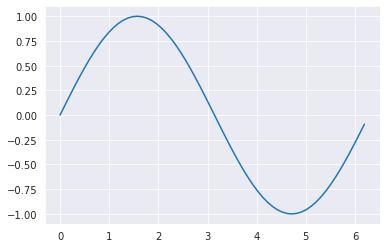

In [3]:
t = np.linspace(0, 32*np.pi, 1024)# np.arange(0, 32*np.pi, np.pi/20)
x = np.sin(t)
plt.plot(t[:64], x[:64]);

In [4]:
window = 64
params = {
    'batch_size': 10,
    'shuffle': False#True
}
train_loader = data.create_data_loader(
    x=torch.tensor(x),
    anomalies=torch.zeros(len(x)),
    window=window,
    device=device,
    **params
)

In [5]:
epochs = 10
params = {
    "out_channels_1": 16,
    "kernel_size_1": 32,
    "stride_1": 1,
    "padding_1": 0,
    "out_channels_2": 32,
    "kernel_size_2": 5,
    "stride_2": 1,
    "padding_2": 0,
    "max_pool": 2,
    "linear_out_1": 128,
}
model = DeepAnt(
        window_size=window,
        lr=1e-4,
        Optimizer=torch.optim.Adam,
        device=device,
        **params
).to(device)
model.train(train_loader=train_loader, validation_loader=None,
            epochs=epochs, model_name="DeepAnt", logdir="logs",
            verbose=1)

Epoch 0, dataset train: Loss - 0.399943, MSE - 0.399943
Epoch 1, dataset train: Loss - 0.105797, MSE - 0.105797
Epoch 2, dataset train: Loss - 0.001148, MSE - 0.001148
Epoch 3, dataset train: Loss - 0.000216, MSE - 0.000216
Epoch 4, dataset train: Loss - 0.000078, MSE - 0.000078
Epoch 5, dataset train: Loss - 0.000036, MSE - 0.000036
Epoch 6, dataset train: Loss - 0.000022, MSE - 0.000022
Epoch 7, dataset train: Loss - 0.000016, MSE - 0.000016
Epoch 8, dataset train: Loss - 0.000012, MSE - 0.000012
Epoch 9, dataset train: Loss - 0.000010, MSE - 0.000010


In [6]:
loss_sum = 0
y_preds = None
for tmp_x, tmp_y, tmp_anomalies in train_loader:
    y_pred = model(tmp_x)[:, 0].cpu().detach().numpy()
    if y_preds is None:
        y_preds = y_pred
    else:
        y_preds = np.concatenate([y_preds, y_pred])

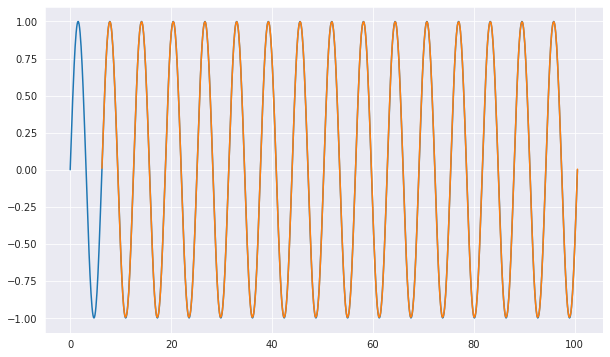

In [7]:
t = np.linspace(0, 32*np.pi, 1024)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t, np.sin(t))
ax.plot(t[window:len(y_preds)+window], y_preds);

In [8]:
#!rm -rf ./logs/DeepAnt